In [2]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd
import matplotlib as mpl

import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS

In [3]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/appliedNNdata/17thRun/sub0/"
#nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/appliedNNdata/15thRun/sub0/"

In [6]:
Ups4S_file = uproot.open(nfs_path + "Ups4S_NN_predicted.root:variables;1")
df_Ups4S = Ups4S_file.arrays(library="pd")

In [ ]:
FSPs_file = uproot.open(nfs_path + "FSPs.root:variables;1")
df_FSPs = FSPs_file.arrays(library="pd")

In [ ]:
evt_counter_file = uproot.open(nfs_path + "evt_counter.root:variables;1")
df_evt_counter = evt_counter_file.arrays(library="pd")

In [ ]:
df_evt_counter.groupby(["__event__","__production__"]).ngroups

In [ ]:
print(df_evt_counter.shape[0])

In [ ]:
print(df_Ups4S.shape[0])
print(df_Ups4S["__event__"].nunique())
print(df_FSPs.shape[0])

In [ ]:
print(df_Ups4S.groupby(["__event__","__production__"]).ngroups)
print(df_Ups4S["__event__"].nunique())

## save df's

In [ ]:
df_FSPs.to_csv(nfs_path + "FSPs_df.csv")
df_Ups4S.to_csv(nfs_path + "Ups4S_df.csv")

In [ ]:
df_evt_counter.to_csv(nfs_path + "evt_counter_df.csv")

## load df's

In [4]:
df_Ups4S = pd.read_csv(nfs_path + "Ups4S_df.csv")
df_FSPs = pd.read_csv(nfs_path + "FSPs_df.csv")
#df_evt_counter = pd.read_csv(nfs_path + "evt_counter_df.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/appliedNNdata/17thRun/sub0/Ups4S_df.csv'

In [ ]:
df_Ups4S

# Analysis

In [ ]:
df_Ups4S.groupby(["__event__","__production__"]).ngroups

## check DO decays

In [ ]:
df_Ups4S['Bsig_uniqParID'] = df_Ups4S.apply(whichBisSig_NAHS, axis=1)

In [ ]:
df_Ups4S['Bsig_uniqParID'].value_counts()

In [ ]:
df_Ups4S['D0_decay'] = df_Ups4S.apply(D0_decay_type, axis=1)

In [ ]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 
#BCS_df = df_Ups4S.sort_values("abs_m2RecoilSignalSide",ascending=True).drop_duplicates(subset=("__event__"), keep='first')

In [ ]:
df_Ups4S['D0_decay'].value_counts()

In [ ]:
df_Ups4S = df_Ups4S[df_Ups4S['D0_decay'] != "notWanted"]

In [ ]:
df_Ups4S.groupby(["__event__","__production__"]).ngroups

In [ ]:
df_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Ups4S["__event__"])]

## check for D* -> D0 pi

In [ ]:
print(df_Ups4S.shape[0])
print(df_Ups4S["__event__"].nunique())
print(df_FSPs.shape[0])

In [ ]:
tmp = df_Ups4S[((df_Ups4S["Bsig_uniqParID"] == 83886081.0)  &
            (df_Ups4S["genUp4S_PDG_0_0_0"].abs() == 421.0)  & # 421=D0
            (df_Ups4S["genUp4S_PDG_0_0_1"].abs() == 211.0)  & # 211=pion
            (df_Ups4S["genUp4S_PDG_0_0_2"].isna() == True)   # no particle 
              |
        ((df_Ups4S["Bsig_uniqParID"] == 83886082.0)  &
            (df_Ups4S["genUp4S_PDG_1_0_0"].abs() == 421.0)  & # 421=D0
            (df_Ups4S["genUp4S_PDG_1_0_1"].abs() == 211.0)  & # 211=pion
            (df_Ups4S["genUp4S_PDG_1_0_2"].isna() == True)))] # no particle 

tmp_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Ups4S["__event__"])]

In [ ]:
print(tmp.shape[0])
print(tmp["__event__"].nunique())
print(tmp_FSPs.shape[0])

### add and check cols

In [ ]:
df_FSPs['B_ID'] = df_FSPs.apply(B_ID, axis=1)

In [ ]:
df_Ups4S['Bsig_uniqParID_pdMethod'] = df_Ups4S.apply(whichBisSig, axis=1)

In [ ]:
Hc_motherB_df = df_FSPs[df_FSPs["NN_prediction"].isna() == True].drop_duplicates(subset=("__event__"), keep='first')

In [ ]:
Hc_motherB_df["B_tag_ID"] = Hc_motherB_df["B_ID"]

In [ ]:
Hc_motherB_df[["__event__","__production__","B_ID","B_tag_ID","NN_prediction"]]

In [ ]:
df_FSPs.shape[0]

In [ ]:
df_FSPs = pd.merge(df_FSPs,Hc_motherB_df[["__event__","__production__","B_tag_ID"]], on=["__event__","__production__"])

In [ ]:
df_FSPs.shape[0]

In [ ]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        B_tagID = s['B_tag_ID']
        
        if int(s['B_ID']) == B_tagID:
            label = 1 # X
        else:
            label = 2 # Bsig
    return label
df_FSPs['label'] = df_FSPs.apply(labels, axis=1)

In [ ]:
df_FSPs["correct_pred"] = (df_FSPs["label"] == df_FSPs["NN_prediction"]).astype(int)

In [ ]:
df_FSPs["correct_pred"].describe()

## see correct prediction rate of NN

In [ ]:
df_FSPs["correct_pred"].describe()

In [ ]:
df_FSPs["NN_prediction"].describe()

In [ ]:
df_FSPs[df_FSPs["NN_prediction"].notna() == True].shape[0]/df_FSPs.shape[0]

In [ ]:
nonHc_FSPs = df_FSPs[df_FSPs["NN_prediction"].notna() == True]

In [ ]:
nonHc_FSPs[nonHc_FSPs["NN_prediction"].notna() == True].shape[0]/nonHc_FSPs.shape[0]

In [ ]:
nonHc_FSPs["correct_pred"].describe()

In [ ]:
nonHc_FSPs.shape[0]

## lepton based truth matching

In [10]:
df_Ups4S["lep_motherPDG"].value_counts()

-511.0      519856
 511.0      382099
-411.0      272749
-421.0      215440
 113.0      205209
             ...  
 10213.0         4
 215.0           4
-30343.0         2
 335.0           2
 3334.0          2
Name: lep_motherPDG, Length: 136, dtype: int64

In [11]:
df_Ups4S["lep_PDG"].value_counts()

 13.0    1382006
-13.0     891243
 11.0     839822
-11.0     556622
Name: lep_PDG, dtype: int64

In [12]:
df_Ups4S["lep_mcPDG"].value_counts()

-211.0     1195251
 211.0      780060
 13.0       442391
 11.0       431094
-13.0       323260
-11.0       298636
-321.0       66838
 321.0       36582
-2212.0       5306
 2212.0       3928
Name: lep_mcPDG, dtype: int64

In [8]:
def lep_typeMC(s):
    label = "none"
    if np.isnan(s["lep_mcPDG"]) == True:
        return label
    
    abs_lep_mcPDG = int(abs(s["lep_mcPDG"]))
    if abs_lep_mcPDG == 13:
        label = "mu"
    elif abs_lep_mcPDG == 11:
        label = "e" 
    return label

df_Ups4S['lep_typeMC'] = df_Ups4S.apply(lep_typeMC, axis=1)

def lep_type(s):
    label = "none"
    if np.isnan(s["lep_PDG"]) == True:
        return label
    
    abs_lep_PDG = int(abs(s["lep_PDG"]))
    if abs_lep_PDG == 13:
        label = "mu"
    elif abs_lep_PDG == 11:
        label = "e" 
    return label
df_Ups4S['lep_type'] = df_Ups4S.apply(lep_type, axis=1)

In [9]:
df_Ups4S['lep_typeMC'].value_counts()

none    2174312
mu       765651
e        729730
Name: lep_typeMC, dtype: int64

In [10]:
groups_lep = pd.DataFrame({'count' : df_Ups4S.groupby( ["lep_typeMC","lep_type"] ).size()}).reset_index()
groups_lep

,lep_typeMC,lep_type,count
0,e,e,684056
1,e,mu,45674
2,mu,e,55689
3,mu,mu,709962
4,none,e,656699
5,none,mu,1517613


In [11]:
def lep_MC_truth(s):
    label = 0
    if np.isnan(s["lep_motherPDG"]) == True:
        return label
    if s["lep_typeMC"] == "none":
        return label
    
    abs_lep_motherPDG = int(abs(s["lep_motherPDG"]))
    if abs_lep_motherPDG == 511:
        label = 1
   
    return label

df_Ups4S['lep_MC_truth'] = df_Ups4S.apply(lep_MC_truth, axis=1)

In [12]:
df_Ups4S['lep_MC_truth']
df_Ups4S["lep_MC_truth"]
df_Ups4S

,Unnamed: 0,__experiment__,__run__,__event__,__production__,__candidate__,__ncandidates__,__weight__,m2RecoilSignalSide,foxWolframR2_maskedNaN,...,Dst_mccmpy,Dst_mccmpz,Dst_DeltaM,Dst_isSignal,roeE_ofUps4S,E_predicted_bg_gammas,mcPDG,lep_typeMC,lep_type,lep_MC_truth
0,0,1003,0,2331170,16816,0,12,1.0,3.236552,0.217161,...,0.0,-0.000447,0.560764,0.0,4.047381,0.714576,300553.0,none,e,0
1,1,1003,0,2331170,16816,1,12,1.0,3.236552,0.217161,...,0.0,-0.000447,0.791285,0.0,4.047381,0.714576,300553.0,none,e,0
2,2,1003,0,2331170,16816,2,12,1.0,3.430173,0.217161,...,0.0,-0.000447,0.560764,0.0,4.047381,0.714576,300553.0,none,e,0
3,3,1003,0,2331170,16816,3,12,1.0,3.430173,0.217161,...,0.0,-0.000447,0.791285,0.0,4.047381,0.714576,300553.0,none,e,0
4,4,1003,0,2331170,16816,4,12,1.0,7.120278,0.217161,...,0.0,-0.000447,0.560764,0.0,5.055230,0.714576,300553.0,none,e,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3669688,3669688,1003,0,7946459,16816,7,8,1.0,5.835685,0.091065,...,0.0,0.004641,0.458424,0.0,3.867183,0.391425,NaN,none,e,0
3669689,3669689,1003,0,7946573,16816,0,4,1.0,2.600595,0.136367,...,0.0,-0.005555,0.334528,0.0,1.039262,0.000000,NaN,mu,mu,1
3669690,3669690,1003,0,7946573,16816,1,4,1.0,0.487114,0.136367,...,NaN,NaN,0.350873,NaN,0.769260,0.000000,NaN,mu,mu,1
3669691,3669691,1003,0,7946573,16816,2,4,1.0,2.600595,0.136367,...,0.0,-0.005555,0.165961,0.0,1.039262,0.000000,NaN,mu,mu,1


In [13]:
df_Ups4S['lep_MC_truth'].describe()

count    3.669693e+06
mean     1.596856e-01
std      3.663142e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: lep_MC_truth, dtype: float64

## save dfs now with all labels added

In [ ]:
nonHc_FSPs.to_csv(nfs_path + "nonHc_FSPs_df_wLabels.csv")

In [ ]:
df_Ups4S.to_csv(nfs_path + "Ups4S_df_wLabels.csv")

In [17]:
print("worked")

worked


## load dfs with labels

In [5]:
df_Ups4S = pd.read_csv(nfs_path + "Ups4S_df_wLabels.csv")

In [ ]:
nonHc_FSPs = pd.read_csv(nfs_path + "nonHc_FSPs_df_wLabels.csv")

In [6]:
df_Ups4S.groupby(["__event__","__production__"]).ngroups

197986

In [19]:
df_Ups4S["lep_MC_truth"]

0          0
1          0
2          0
3          0
4          0
          ..
3669688    0
3669689    1
3669690    1
3669691    1
3669692    1
Name: lep_MC_truth, Length: 3669693, dtype: int64

## more analysis

In [ ]:
numFSPs_all = pd.DataFrame({'count' : nonHc_FSPs.groupby( ["__event__","__production__"] ).size()}).reset_index()
numFSPs_all["count"].hist()

In [ ]:
percCorrect_df = pd.DataFrame({'frac. correct FSPs' : nonHc_FSPs.groupby(["__event__","__production__","correct_pred"] ).size()/nonHc_FSPs.groupby( ["__event__","__production__"] ).size()}).reset_index()

In [ ]:
percCorrect_df['frac. correct FSPs'].hist()

## BCS

In [ ]:
print(df_Ups4S.shape[0])
print(df_Ups4S["__event__"].nunique())
print(nonHc_FSPs.shape[0])

In [ ]:
nonHc_FSPs.keys()

In [ ]:
for key in df_Ups4S.keys():
    print(key)

In [5]:
df_Ups4S.shape[0]

3669693

In [ ]:
df_Ups4S[["__event__"]].nunique()

In [ ]:
df_Ups4S.groupby(["__event__","__production__"]).ngroups

In [ ]:
variables=["Up4S_isSig","Dst_isSignal","D_isSignal","dau0_dau0_isSignal","Hc_isSignalAcceptMissingGamma","dau0_isSignal","dau1_isSignal"]
for var in variables:
    print('\n',var)
    print(df_Ups4S[var].describe())
    

In [ ]:
bins = np.linspace(0, 10, 50)
df_Ups4S["roeE_ofUps4S"].hist(bins=bins)

In [ ]:
bins = np.linspace(0, 2, 50)
df_Ups4S["E_predicted_bg_gammas"].hist(bins=bins)

In [ ]:
bins = np.linspace(-4, 4, 50)
df_Ups4S.hist("m2RecoilSignalSide", bins=bins, by='lep_MC_truth')

In [ ]:
bins = np.linspace(-4, 4, 50)
df_Ups4S.hist("m2RecoilSignalSide", bins=bins, by='dau1_isSignal')

In [ ]:
df_Ups4S["lep_MC_truth"].describe()

In [ ]:
df_Ups4S["Up4S_isSig"].describe()

197986
197986
197986
197986


KeyError: 'lep_MC_truth'

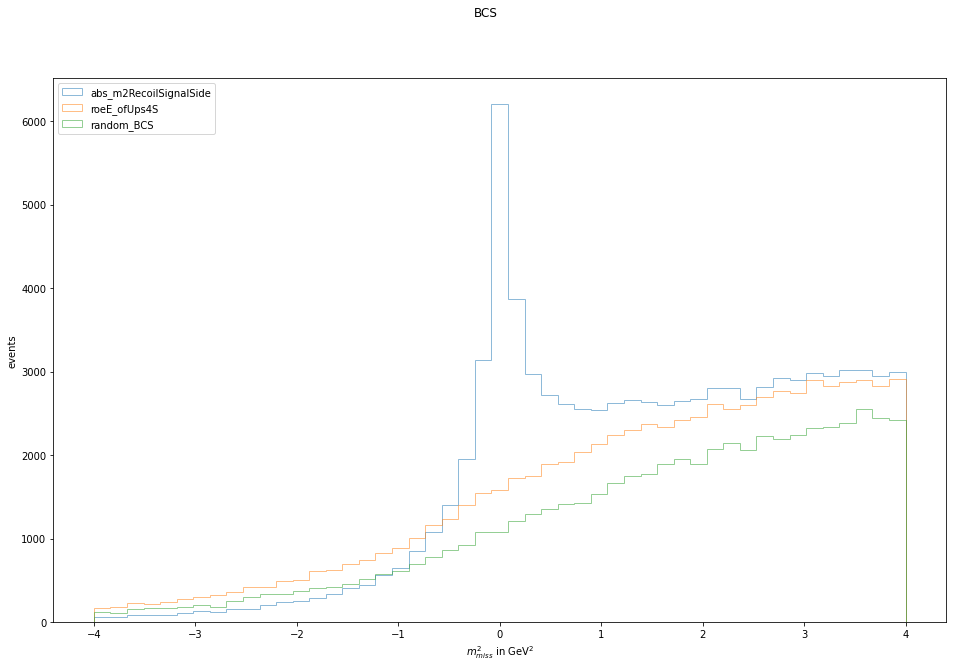

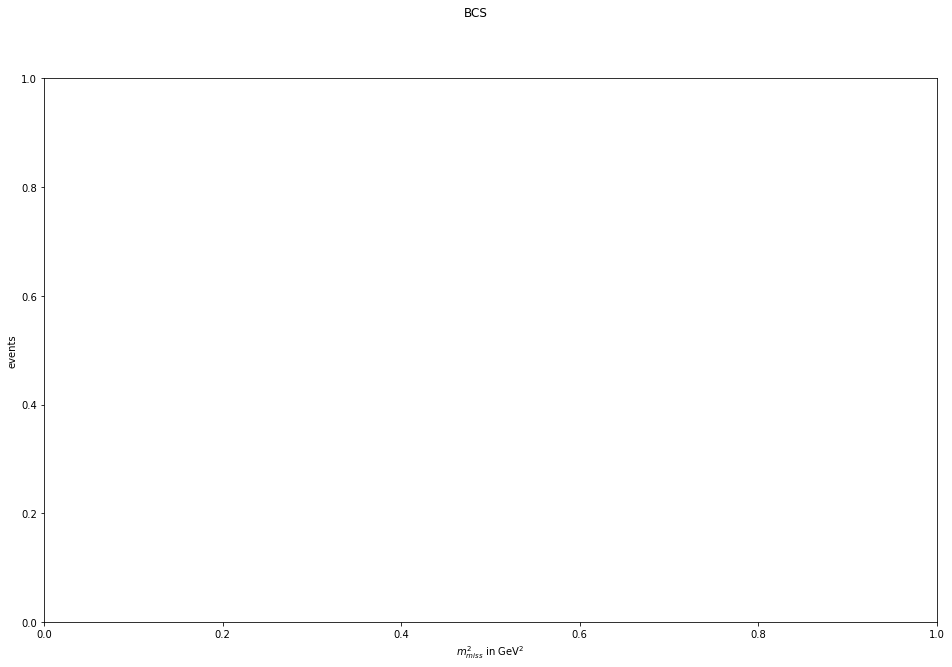

In [4]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 

for lep_truth in ["off","on"]:
    fig, ax = plt.subplots()
    fig.suptitle('BCS')

    for var in ["abs_m2RecoilSignalSide","roeE_ofUps4S","random_BCS"]:

        if var == "random_BCS":
            # this takes a sample of all events which results in shuffling the evts
            tmp = df_Ups4S.sample(frac=1)
            # now keeping the first results in random BCS
            tmp = tmp.drop_duplicates(subset=("__event__"), keep='first')
        else:
            tmp = df_Ups4S.sort_values(var,ascending=True).drop_duplicates(subset=("__event__"), keep='first')



        print(tmp.shape[0])
        bins = np.linspace(-4, 4, 50)

        fig.set_size_inches(16, 10)

        ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
        ax.set_ylabel("events")
        
        if lep_truth == "off":
            ax.hist(tmp.m2RecoilSignalSide, bins, alpha=0.5, label=var ,histtype='step')
        elif lep_truth == "on":    
            ax.hist(tmp[tmp["lep_MC_truth"] == 1].m2RecoilSignalSide, bins, alpha=0.5, label=var + " lep truth matching == 1" ,histtype='step')

        ax.legend(loc='upper left')



    plt.savefig(f'plots/ONLINE_APP_FIXED_onlineNN_m2Recoil_BCS_lepTruthCut_{lep_truth}_17th.pdf')

In [22]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 

In [ ]:


fig, ax = plt.subplots()
fig.suptitle('BCS')

for var in ["abs_m2RecoilSignalSide"]:

    tmp = df_Ups4S.sort_values(var,ascending=True).drop_duplicates(subset=("__event__"), keep='first')



    print(tmp.shape[0])
    bins = np.linspace(-4, 4, 50)

    fig.set_size_inches(16, 10)

    ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
    ax.set_ylabel("events")

    ax.hist(tmp.m2RecoilSignalSide, bins, alpha=0.5, label=var ,histtype='step')
    ax.hist(tmp[tmp["lep_MC_truth"] == 1].m2RecoilSignalSide, bins, alpha=0.5, label=var + " lep truth matching == 1" ,histtype='step')

    ax.legend(loc='upper left')



    plt.savefig(f'plots/ONLINE_APP_FIXED_onlineNN_m2Recoil_BCS_lepTruthCut_ONLY_abs_m2RecoilSignalSide_17th.pdf')

In [23]:
BCS_df = df_Ups4S.sort_values("abs_m2RecoilSignalSide",ascending=True).drop_duplicates(subset=("__event__"), keep='first')

In [ ]:
bins = np.linspace(-4, 4, 50)
BCS_df["m2RecoilSignalSide"].hist(bins=bins)

In [20]:
BCS_df["m2RecoilSignalSide"].describe()

NameError: name 'BCS_df' is not defined

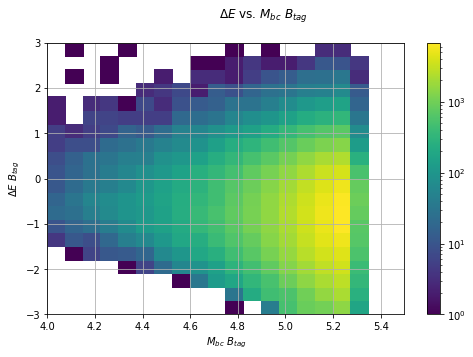

In [8]:
fig, ax = plt.subplots()
fig.suptitle(r'$\Delta E$ vs. $M_{bc}$ $B_{tag}$')

bins = np.linspace(-4, 4, 50)

fig.set_size_inches(8, 5)

ax.set_xlabel(r'$M_{bc}$ $B_{tag}$')
ax.set_ylabel(r'$\Delta E$ $B_{tag}$')


#ax.legend(loc='upper left')
h = ax.hist2d(BCS_df.dau0_Mbc,BCS_df.dau0_deltaE, range=[[4, 5.5], [-3, 3]], bins=20,
          norm=mpl.colors.LogNorm())

plt.grid()
fig.colorbar(h[3], ax=ax)


plt.savefig('plots/ONLINE_APP_FIXED_onlineNN_2D_deltaE_Mbc_17th.pdf')

In [ ]:
bins = np.linspace(4, 6, 50)
BCS_df["dau0_Mbc"].hist(bins=bins)

In [ ]:
bins = np.linspace(-4, 4, 50)
BCS_df["dau0_deltaE"].hist(bins=bins)

In [ ]:
bins = np.linspace(0, 2, 50)
BCS_df["Dst_DeltaM"].hist(bins=bins)

In [ ]:
bins = np.linspace(0, 4, 50)
BCS_df["D_M"].hist(bins=bins)

In [ ]:
bins = np.linspace(0, 4, 50)
BCS_df["Dst_M"].hist(bins=bins)

In [ ]:
bins = np.linspace(0, 4, 50)
BCS_df["Dst_pt"].hist(bins=bins)

In [ ]:
bins = np.linspace(0, 4, 50)
BCS_df["lep_pt"].hist(bins=bins)

In [25]:
deltaE_cut=0.5

In [ ]:
cut name & variable & lower limit & upper limit    \\  \hline
#Btag Mbc     & dau0\_Mbc    & 5.0  &      \\
#Btag deltaE  & dau0\_Mbc    & -2, & -1.0  \\
foxWolframR2 & foxWolframR2 &      & 0.3  \\
#Dst\_pt      & Dst\_pt      &      & 2.4  \\
#lep\_pt      & lep\_pt      & 0.7  &      \\
D0 mass      & D\_M         & 1.8  & 1.95 \\
Dst mass     & Dst\_M       & 1.8  & 2.2  \\
hadr. Btag   & N\_lep\_Btag &      & 0   

<AxesSubplot:>

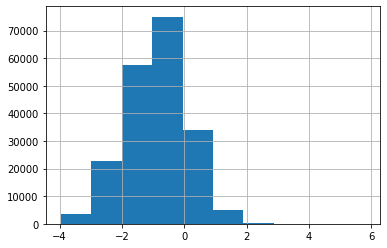

In [30]:
BCS_df.dau0_deltaE.hist()

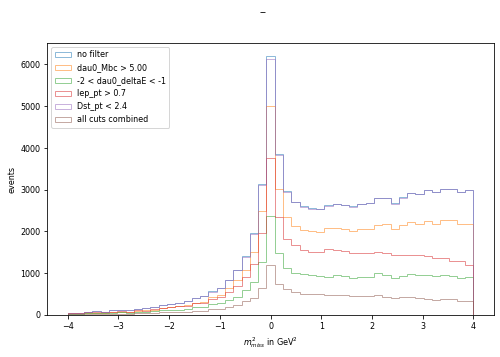

In [45]:
fig, ax = plt.subplots()
    
bins = np.linspace(-4, 4, 50)

fig.suptitle('--')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
ax.set_ylabel("events")

ax.hist(BCS_df.m2RecoilSignalSide, bins, alpha=0.5, label="no filter" ,histtype='step')
ax.hist(BCS_df[BCS_df.dau0_Mbc > 5.00].m2RecoilSignalSide, bins, alpha=0.5, label="dau0_Mbc > 5.00" ,histtype='step')
ax.hist(BCS_df[(BCS_df.dau0_deltaE > (-1.5-deltaE_cut)) & (BCS_df.dau0_deltaE < (-1.5+deltaE_cut))].m2RecoilSignalSide, bins, alpha=0.5, label="-2 < dau0_deltaE < -1",histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4) & (BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4 & lep_pt > 1.0" ,histtype='step')
ax.hist(BCS_df[(BCS_df.lep_pt > 0.7)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt > 0.7" ,histtype='step')
ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4" ,histtype='step')
ax.hist(BCS_df[(BCS_df.lep_pt > 0.7) & (BCS_df.dau0_deltaE > (-1.5-deltaE_cut)) & (BCS_df.dau0_deltaE < (-1.5+deltaE_cut)) & (BCS_df.dau0_Mbc > 5.00) & (BCS_df.Dst_pt < 2.4)].m2RecoilSignalSide, bins, alpha=0.5, label="all cuts combined" ,histtype='step')

#tmp2 = BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)]
#ax.hist(tmp2[(tmp2.D_M > 1.8) & (tmp2.D_M < 1.95)].m2RecoilSignalSide, bins, alpha=0.5, label="plus D M cut" ,histtype='step')

ax.legend(loc='upper left')


plt.savefig('plots/ONLINE_APP_FIXED_onlineNN_m2RecoilFilters_17th.pdf')

In [ ]:


D_modes=[21001.0, 21003.0, 21002.0, 21004.0]

for i, Dmode in enumerate(D_modes):
    
    var = "D_M"
    
    idx=i % dim_x
    idy=math.floor(i/dim_x)
    print(idx, idy, var)
    
    ax = axs[idx, idy]   
    
    bins = np.linspace(0, 4, 50)
    ax.set_title(f'{Dmode_dict[Dmode]}')

    #ax.set_xlabel(r'number of wrong predictions per event')
    ax.set_ylabel("events per bin",fontsize=font_size)
    
    mcTruth_df_Dmode = mcTruth_df[mcTruth_df["D_decayModeID"] == Dmode]
    mcBG_df_Dmode = mcBG_df[mcBG_df["D_decayModeID"] == Dmode]
    
    D0_mass = 1.86483
    ax.axvline(x=D0_mass, color='r', label='$m_{D^0}$ - PDG value')
    
    
    #plt.xticks(np.arange(0, num_steps, step=1))
    ax.hist([mcTruth_df_Dmode[var],mcBG_df_Dmode[var]], bins, stacked=True, density=False, alpha=1,
           label=["MC truth","background"])
    

    
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.tick_params(axis='both', which='minor', labelsize=font_size)

    ax.legend(loc='upper right')

    #plt.grid()



In [37]:
dim_x=3
import math
D_modes=[21001.0, 21003.0, 21002.0, 21004.0,3,4]

for i, Dmode in enumerate(D_modes):
    
    idx=i % dim_x
    idy=math.floor(i/dim_x)
    print(idx, idy)

0 0
1 0
2 0
0 1
1 1
2 1


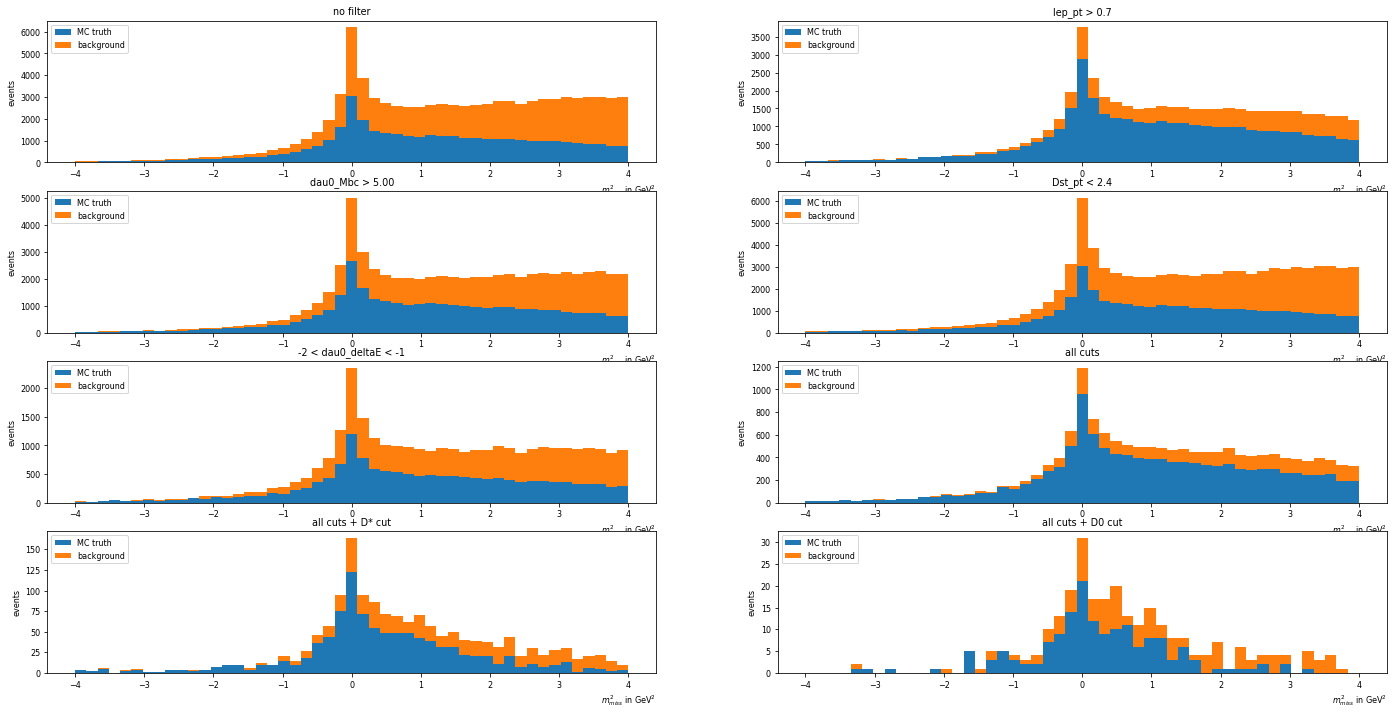

In [54]:
dim_x = 4
fig, axs = plt.subplots(dim_x, 2)
fig.set_size_inches(24, 12)
font_size=8
plt.rcParams.update({'font.size': font_size})

mcTruth_df = BCS_df[BCS_df["lep_MC_truth"] == 1]
mcBG_df = BCS_df[BCS_df["lep_MC_truth"] == 0]


bins = np.linspace(-4, 4, 50)



ax = axs[0,0]  
ax.set_title("no filter")
ax.hist([mcTruth_df["m2RecoilSignalSide"],mcBG_df["m2RecoilSignalSide"]], bins, 
        label=["MC truth","background"] , stacked=True, density=False, alpha=1)

ax = axs[1,0]  
ax.set_title("dau0_Mbc > 5.00")
ax.hist([mcTruth_df[mcTruth_df.dau0_Mbc > 5.00]["m2RecoilSignalSide"],
         mcBG_df[mcBG_df.dau0_Mbc > 5.00]["m2RecoilSignalSide"]], bins, 
        label=["MC truth","background"] , stacked=True, density=False, alpha=1)

ax = axs[2,0]  
ax.set_title("-2 < dau0_deltaE < -1")
ax.hist([mcTruth_df[(mcTruth_df.dau0_deltaE > (-1.5-deltaE_cut)) & 
            (mcTruth_df.dau0_deltaE < (-1.5+deltaE_cut))]["m2RecoilSignalSide"],
         mcBG_df[(mcBG_df.dau0_deltaE > (-1.5-deltaE_cut)) & 
            (mcBG_df.dau0_deltaE < (-1.5+deltaE_cut))]["m2RecoilSignalSide"]], bins, 
        label=["MC truth","background"] , stacked=True, density=False, alpha=1)

ax = axs[0,1]  
ax.set_title("lep_pt > 0.7")
ax.hist([mcTruth_df[(mcTruth_df.lep_pt > 0.7)]["m2RecoilSignalSide"],
         mcBG_df[(mcBG_df.lep_pt > 0.7)]["m2RecoilSignalSide"]], bins, 
        label=["MC truth","background"] , stacked=True, density=False, alpha=1)


ax = axs[1,1]  
ax.set_title("Dst_pt < 2.4")
ax.hist([mcTruth_df[(mcTruth_df.Dst_pt < 2.4)]["m2RecoilSignalSide"],
         mcBG_df[(mcBG_df.Dst_pt < 2.4)]["m2RecoilSignalSide"]], bins, 
        label=["MC truth","background"] , stacked=True, density=False, alpha=1)


allCuts_mcTruth_df = mcTruth_df[(mcTruth_df.lep_pt > 0.7) & (mcTruth_df.dau0_deltaE > (-1.5-deltaE_cut)) &
                    (mcTruth_df.dau0_deltaE < (-1.5+deltaE_cut)) &
                    (mcTruth_df.dau0_Mbc > 5.00) & (mcTruth_df.Dst_pt < 2.4)]

allCuts_mcBG_df = mcBG_df[(mcBG_df.lep_pt > 0.7) & (mcBG_df.dau0_deltaE > (-1.5-deltaE_cut)) &
                    (mcBG_df.dau0_deltaE < (-1.5+deltaE_cut)) &
                    (mcBG_df.dau0_Mbc > 5.00) & (mcBG_df.Dst_pt < 2.4)]

ax = axs[2,1]  
ax.set_title("all cuts")
ax.hist([allCuts_mcTruth_df["m2RecoilSignalSide"],
         allCuts_mcBG_df["m2RecoilSignalSide"]], bins, 
        label=["MC truth","background"] , stacked=True, density=False, alpha=1)


ax = axs[3,1]  
ax.set_title("all cuts + D0 cut")
ax.hist([allCuts_mcTruth_df[(allCuts_mcTruth_df.D_M < 1.95) & (allCuts_mcTruth_df.D_M > 1.8)]["m2RecoilSignalSide"],
         allCuts_mcBG_df[(allCuts_mcBG_df.D_M < 1.95) & (allCuts_mcBG_df.D_M > 1.8)]["m2RecoilSignalSide"]], bins, 
        label=["MC truth","background"] , stacked=True, density=False, alpha=1)


ax = axs[3,0]  
ax.set_title("all cuts + D* cut")
ax.hist([allCuts_mcTruth_df[(allCuts_mcTruth_df.Dst_M < 2.2) & (allCuts_mcTruth_df.Dst_M > 1.8)]["m2RecoilSignalSide"],
         allCuts_mcBG_df[(allCuts_mcBG_df.Dst_M < 2.2) & (allCuts_mcBG_df.Dst_M > 1.8)]["m2RecoilSignalSide"]], bins, 
        label=["MC truth","background"] , stacked=True, density=False, alpha=1)




#ax.hist([mcTruth_df["Ds_massDifference"],mcBG_df["Ds_massDifference"]], bins, stacked=True, density=False, alpha=1,
#       label=["MC truth","background"])


for i in range(dim_x*2):
    
    idx=i % dim_x
    idy=math.floor(i/dim_x)
    ax = axs[idx,idy]
    ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$',loc='right')
    ax.set_ylabel("events")
    ax.legend(loc='upper left')


plt.savefig('plots/m2recoilFilter_MCtruth_bg_stacked.pdf')

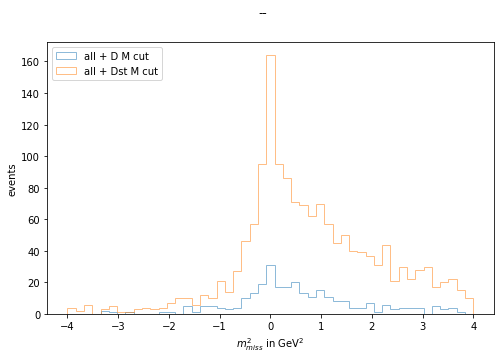

In [33]:
fig, ax = plt.subplots()
    
bins = np.linspace(-4, 4, 50)

fig.suptitle('--')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
ax.set_ylabel("events")

#ax.hist(BCS_df.m2RecoilSignalSide, bins, alpha=0.5, label="no filter" ,histtype='step')
#ax.hist(BCS_df[BCS_df.dau0_Mbc > 5.00].m2RecoilSignalSide, bins, alpha=0.5, label="dau0_Mbc > 5.00" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.dau0_deltaE > -.2) & BCS_df.dau0_deltaE < .2].m2RecoilSignalSide, bins, alpha=0.5, label="abs(dau0_deltaE) < 0.2" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4) & (BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4 & lep_pt > 1.0" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt > 1.0" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt,dau0_deltaE,dau0_Mbc" ,histtype='step')

tmp2 = BCS_df[(BCS_df.lep_pt > 0.7) & ((BCS_df.dau0_deltaE > (-1.5-deltaE_cut))) & (BCS_df.dau0_deltaE < (-1.5+deltaE_cut)) & (BCS_df.dau0_Mbc > 5.00) & (BCS_df.Dst_pt < 2.4)]
ax.hist(tmp2[(tmp2.D_M > 1.8) & (tmp2.D_M < 1.95)].m2RecoilSignalSide, bins, alpha=0.5, label="all + D M cut" ,histtype='step')
ax.hist(tmp2[(tmp2.Dst_M > 1.8) & (tmp2.Dst_M < 2.2)].m2RecoilSignalSide, bins, alpha=0.5, label="all + Dst M cut" ,histtype='step')

ax.legend(loc='upper left')

plt.savefig('plots/ONLINE_APP_FIXED_onlineNN_m2Recoil_plus_DmassCut_17th.pdf')

In [56]:
tmp2[(tmp2.D_M > 1.8) & (tmp2.D_M < 1.95)].m2RecoilSignalSide.shape

(88,)

In [57]:
tmp2[(tmp2.D_M > 1.7) & (tmp2.D_M < 2.05)].m2RecoilSignalSide.shape

(207,)

## analyse how many errors per evt etc

In [55]:
percCorrect_df = pd.DataFrame({'frac. correct FSPs' : nonHc_FSPs.groupby(["__event__","correct_pred"] ).size()/nonHc_FSPs.groupby( ["__event__"] ).size(),
                              'num corr preds' : nonHc_FSPs.groupby(["__event__","correct_pred"] ).size()}).reset_index()
percCorrect_df = percCorrect_df[percCorrect_df["correct_pred"] == 1]
numFSPs = pd.DataFrame({'numFSPs' : nonHc_FSPs.groupby( ["__event__"] ).size()}).reset_index()

online_NN_results = pd.merge(percCorrect_df[["__event__","frac. correct FSPs","num corr preds"]],
                             numFSPs[["__event__","numFSPs"]],on=["__event__"],how='outer')
online_NN_results

,__event__,frac. correct FSPs,num corr preds,numFSPs
0,2422,0.625000,10,16
1,2975,0.888889,8,9
2,3765,0.625000,10,16
3,5639,0.777778,14,18
4,5845,0.642857,9,14
...,...,...,...,...
16240,50984167,0.933333,14,15
16241,50988678,0.700000,14,20
16242,50988743,0.777778,7,9
16243,50991574,0.812500,13,16


In [56]:
online_NN_results['frac. correct FSPs'] = online_NN_results['frac. correct FSPs'].fillna(0)
online_NN_results['num corr preds'] = online_NN_results['num corr preds'].fillna(0)

In [57]:
online_NN_results["num errors"] = online_NN_results["numFSPs"] - online_NN_results["num corr preds"]

## make comparison plots between online/offline application of NN

In [58]:
path_df = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/MM2plotFromPreds/"
offline_NN_results = pd.read_csv(path_df + "offline_NN_results.csv")

In [59]:
offline_NN_results.keys()

Index(['Unnamed: 0', 'event', 'frac. correct FSPs', 'num corr preds',
       'numFSPs', 'px_summed_bg', 'py_summed_bg', 'pz_summed_bg',
       'E_summed_bg', 'CMSpx_summed_bg', 'CMSpy_summed_bg', 'CMSpz_summed_bg',
       'CMSE_summed_bg', 'px_summed_X', 'py_summed_X', 'pz_summed_X',
       'E_summed_X', 'CMSpx_summed_X', 'CMSpy_summed_X', 'CMSpz_summed_X',
       'CMSE_summed_X', 'px_summed_Bs', 'py_summed_Bs', 'pz_summed_Bs',
       'E_summed_Bs', 'CMSpx_summed_Bs', 'CMSpy_summed_Bs', 'CMSpz_summed_Bs',
       'CMSE_summed_Bs', 'Hc_px', 'Hc_py', 'Hc_pz', 'Hc_E', 'Hc_cmpx',
       'Hc_cmpy', 'Hc_cmpz', 'Hc_cmE', 'Hc_cmPx', 'Hc_cmPy', 'Hc_cmPz',
       'num errors', 'Mbc_Btag', 'MM2recoilSignalSide', 'deltaE',
       'summed_wrongPred_p'],
      dtype='object')

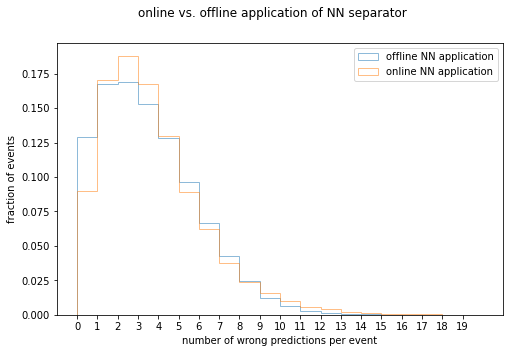

In [60]:
fig, ax = plt.subplots()
num_steps=20
bins = np.linspace(0, num_steps, 21)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of wrong predictions per event')
ax.set_ylabel("fraction of events")

plt.xticks(np.arange(0, num_steps, step=1))

ax.hist(offline_NN_results["num errors"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["num errors"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper right')

#plt.grid()

plt.savefig('plots/ONLINE_APP_FIXED_onlineVSofflineNN_numErrorsPerEvent.pdf')

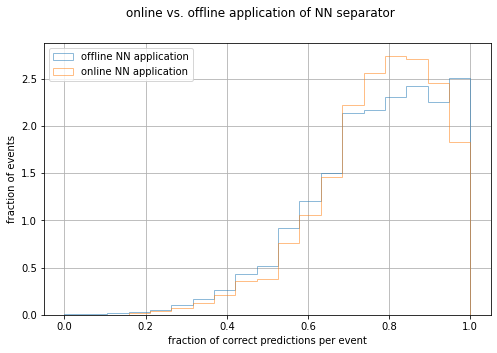

In [61]:
fig, ax = plt.subplots()

bins = np.linspace(0, 1, 20)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'fraction of correct predictions per event')
ax.set_ylabel("fraction of events")

ax.hist(offline_NN_results["frac. correct FSPs"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["frac. correct FSPs"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper left')

plt.grid()

plt.savefig('plots/ONLINE_APP_FIXED_onlineVSofflineNN_fracErrorsPerEvent.pdf')

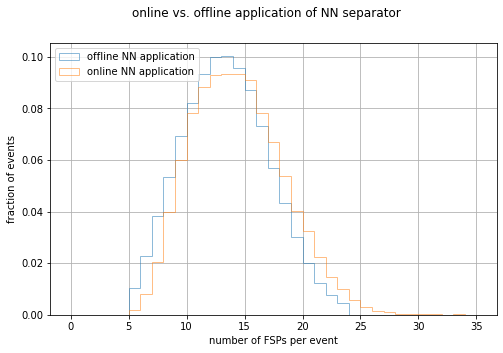

In [62]:
fig, ax = plt.subplots()

bins = np.linspace(0, 35, 36)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of FSPs per event')
ax.set_ylabel("fraction of events")

ax.hist(offline_NN_results["numFSPs"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["numFSPs"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper left')

plt.grid()

plt.savefig('plots/ONLINE_APP_FIXED_onlineVSofflineNN_numFSPs.pdf')

In [146]:
sigprob_cut = 0.01
'anti-D*0:genericsigProb',"anti-D*0:generic",'extraInfo(SignalProbability)>{} and 0.139<massDifference(0)<0.16'.format(sigprob_cut)

('anti-D*0:genericsigProb',
 'anti-D*0:generic',
 'extraInfo(SignalProbability)>0.01 and 0.139<massDifference(0)<0.16')